In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from math import ceil

In [3]:
import torch.nn as nn
import torch
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt
import torchvision

In [36]:
from metrics import Metric, WassersteinApproximation, StructuralSimilarityIndexMeasure, L2Metric, LinfMetric

In [72]:
def get_adv(model, benign_examples, target_labels, metric: Metric, c):
    step_size = 1e-2
    # adversarial_examples = (benign_examples + (50 / 255 * (2 * torch.rand(benign_examples.shape) - 1))).detach()
    adversarial_examples = 0.5 * torch.ones(benign_examples.shape)
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    for i in range(100):
        adversarial_examples.requires_grad = True
        if adversarial_examples.grad is not None:
            adversarial_examples.grad.zero_()
        loss = c * metric(benign_examples, adversarial_examples).sum() \
            + loss_fn(model(adversarial_examples), target_labels)
        # print('--- --- STARTING DIFFERENTIATION --- ---')
        loss.backward()
        # print('--- --- ENDING DIFFERENTIATION --- ---')
        print(f'Inner loop: {i + 1} / 100')
        adversarial_examples = (adversarial_examples - step_size * adversarial_examples.grad.apply_(lambda x: 1 if x >= 0 else -1)).detach()
    return adversarial_examples


def lbfgs_batch(model, benign_examples, labels, metric: Metric):
    batch = len(benign_examples)
    all_adversarial_examples = torch.zeros(batch, 9, 28, 28)
    target_labels = torch.tensor([[i for i in range(10) if i != label] for label in labels])
    for i in range(9):
        print(f'--- {i} ---')
        successful_indexes = []
        unsuccessful_indexes = [i for i in range(batch)]
        c = 100
        while unsuccessful_indexes:
            still_benign_examples = torch.tensor([benign_examples[j].tolist() for j in unsuccessful_indexes])
            still_target_labels = torch.tensor([target_labels[j, i] for j in unsuccessful_indexes])
            adversarial_examples = get_adv(model, still_benign_examples, still_target_labels, metric, c)
            adversarial_preds = torch.argmax(model(adversarial_examples), dim=1)
            indexes_to_delete = []
            for j in range(len(adversarial_examples)):
                # print(j)
                if adversarial_preds[j] != labels[unsuccessful_indexes[j]] or c <= 0.01:
                    all_adversarial_examples[unsuccessful_indexes[j], i, :, :] = adversarial_examples[j, :, :, :]
                    successful_indexes.append(unsuccessful_indexes[j])
                    indexes_to_delete.append(unsuccessful_indexes[j])
            for j in indexes_to_delete:
                unsuccessful_indexes.remove(j)
            c *= 0.1
            # print(f'---switching to c={c}')
    # expanded_examples = benign_examples.expand(batch, 9, 28, 28)
    norms = torch.zeros(batch, 9)
    for i in range(9):
        norms[:, i] = metric(all_adversarial_examples[:, i, :, :].reshape(batch, 1, 28, 28), benign_examples)
        preds = torch.argmax(model(all_adversarial_examples[:,i,:,:].reshape(batch, 1, 28, 28)), dim=1)
        norms[:, i] += torch.tensor([torch.inf if preds[j] == labels[j] else 0 for j in range(batch)])
    selected_adversarial_examples = torch.zeros(benign_examples.shape)
    indexes = torch.argmin(norms, dim=1)
    for i in range(batch):
        selected_adversarial_examples[i, 0, :, :] = all_adversarial_examples[i, indexes[i], :, :]
    return selected_adversarial_examples

In [18]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(1024, 200),
            nn.ReLU(),
            nn.Linear(200, 10),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        return self.seq(x)

In [22]:
model = Model()

In [23]:
batch_size_train = 60
batch_size_test = 1000
epochs = 3
learning_rate = 1e-4
report_every_batch = 20

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        'mnist',
        train=True,
        download=True,
        transform=torchvision.transforms.ToTensor()
    ),
    batch_size=batch_size_train,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        'mnist',
        train=False,
        download=True,
        transform=torchvision.transforms.ToTensor()
    ),
    batch_size=batch_size_test,
    shuffle=False
)

optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

for epoch_id in range(1, epochs + 1):
    for batch_id, (examples, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        preds = model(examples)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()
        if (batch_id + 1) % report_every_batch == 0:
            print(f'Epoch:{epoch_id}/{epochs}; Batch:{batch_id + 1}/{ceil(len(train_loader.dataset) // batch_size_train)}; Loss:{loss.item():.6f}')
    torch.save(model, 'models\\model_v1.model')
    print(f'EPOCH {epoch_id} OUT OF {epochs} DONE')
    print('_________')
    totals = []
    rights = []
    for test_id, (examples, labels) in enumerate(test_loader):
        total_ex_count = len(examples)
        right_ex_count = (torch.argmax(model(examples), dim=1) == labels).sum()
        print(f'Test accuracy: {100 * right_ex_count / total_ex_count} % in the try {test_id + 1}')
        totals.append(total_ex_count)
        rights.append(right_ex_count)
    print(f'Total test accuracy: {100 * sum(rights) / sum(totals)} %')


Epoch:1/3; Batch:20/1000; Loss:2.179547
Epoch:1/3; Batch:40/1000; Loss:1.848521
Epoch:1/3; Batch:60/1000; Loss:1.750116
Epoch:1/3; Batch:80/1000; Loss:1.679086
Epoch:1/3; Batch:100/1000; Loss:1.657850
Epoch:1/3; Batch:120/1000; Loss:1.663301
Epoch:1/3; Batch:140/1000; Loss:1.657521
Epoch:1/3; Batch:160/1000; Loss:1.595390
Epoch:1/3; Batch:180/1000; Loss:1.647463
Epoch:1/3; Batch:200/1000; Loss:1.600450
Epoch:1/3; Batch:220/1000; Loss:1.643055
Epoch:1/3; Batch:240/1000; Loss:1.632173
Epoch:1/3; Batch:260/1000; Loss:1.699594
Epoch:1/3; Batch:280/1000; Loss:1.705993
Epoch:1/3; Batch:300/1000; Loss:1.565385
Epoch:1/3; Batch:320/1000; Loss:1.677871
Epoch:1/3; Batch:340/1000; Loss:1.729574
Epoch:1/3; Batch:360/1000; Loss:1.654966
Epoch:1/3; Batch:380/1000; Loss:1.598305
Epoch:1/3; Batch:400/1000; Loss:1.563097
Epoch:1/3; Batch:420/1000; Loss:1.668767
Epoch:1/3; Batch:440/1000; Loss:1.615050
Epoch:1/3; Batch:460/1000; Loss:1.575811
Epoch:1/3; Batch:480/1000; Loss:1.589144
Epoch:1/3; Batch:500

In [ ]:
model = torch.load('models\\model_v1.model')

In [33]:
def get_benign_examples(model, dataloader, count):
    counter = 0
    benign_examples = torch.zeros(count, 1, dataloader.dataset[0][0].shape[1], dataloader.dataset[0][0].shape[2])
    benign_labels = torch.zeros(count)
    for examples, labels in dataloader:
        preds = model(examples)
        match = (torch.argmax(preds, dim=1) == labels)
        for idx, foo in enumerate(match):
            if foo:
                benign_examples[counter] = examples[idx]
                benign_labels[counter] = labels[idx]
                counter += 1
            if counter >= count:
                break
        if counter >= count:
            break
    return benign_examples, benign_labels

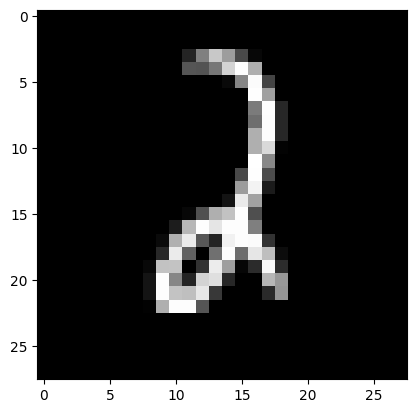

In [34]:
plt.imshow(get_benign_examples(model, train_loader, 10)[0][0, 0], cmap='gray')

In [46]:
batch = 5

benign, labels = get_benign_examples(model, train_loader, batch)


In [67]:

adv_l2 = lbfgs_batch(model, benign, labels, L2Metric())
print('DONE L2')

--- 0 ---
Inner loop: 1 / 100
Inner loop: 2 / 100
Inner loop: 3 / 100
Inner loop: 4 / 100
Inner loop: 5 / 100
Inner loop: 6 / 100
Inner loop: 7 / 100
Inner loop: 8 / 100
Inner loop: 9 / 100
Inner loop: 10 / 100
Inner loop: 11 / 100
Inner loop: 12 / 100
Inner loop: 13 / 100
Inner loop: 14 / 100
Inner loop: 15 / 100
Inner loop: 16 / 100
Inner loop: 17 / 100
Inner loop: 18 / 100
Inner loop: 19 / 100
Inner loop: 20 / 100
Inner loop: 21 / 100
Inner loop: 22 / 100
Inner loop: 23 / 100
Inner loop: 24 / 100
Inner loop: 25 / 100
Inner loop: 26 / 100
Inner loop: 27 / 100
Inner loop: 28 / 100
Inner loop: 29 / 100
Inner loop: 30 / 100
Inner loop: 31 / 100
Inner loop: 32 / 100
Inner loop: 33 / 100
Inner loop: 34 / 100
Inner loop: 35 / 100
Inner loop: 36 / 100
Inner loop: 37 / 100
Inner loop: 38 / 100
Inner loop: 39 / 100
Inner loop: 40 / 100
Inner loop: 41 / 100
Inner loop: 42 / 100
Inner loop: 43 / 100
Inner loop: 44 / 100
Inner loop: 45 / 100
Inner loop: 46 / 100
Inner loop: 47 / 100
Inner loop: 

In [68]:

adv_linf = lbfgs_batch(model, benign, labels, LinfMetric())
print('DONE LINF')

--- 0 ---
Inner loop: 1 / 100
Inner loop: 2 / 100
Inner loop: 3 / 100
Inner loop: 4 / 100
Inner loop: 5 / 100
Inner loop: 6 / 100
Inner loop: 7 / 100
Inner loop: 8 / 100
Inner loop: 9 / 100
Inner loop: 10 / 100
Inner loop: 11 / 100
Inner loop: 12 / 100
Inner loop: 13 / 100
Inner loop: 14 / 100
Inner loop: 15 / 100
Inner loop: 16 / 100
Inner loop: 17 / 100
Inner loop: 18 / 100
Inner loop: 19 / 100
Inner loop: 20 / 100
Inner loop: 21 / 100
Inner loop: 22 / 100
Inner loop: 23 / 100
Inner loop: 24 / 100
Inner loop: 25 / 100
Inner loop: 26 / 100
Inner loop: 27 / 100
Inner loop: 28 / 100
Inner loop: 29 / 100
Inner loop: 30 / 100
Inner loop: 31 / 100
Inner loop: 32 / 100
Inner loop: 33 / 100
Inner loop: 34 / 100
Inner loop: 35 / 100
Inner loop: 36 / 100
Inner loop: 37 / 100
Inner loop: 38 / 100
Inner loop: 39 / 100
Inner loop: 40 / 100
Inner loop: 41 / 100
Inner loop: 42 / 100
Inner loop: 43 / 100
Inner loop: 44 / 100
Inner loop: 45 / 100
Inner loop: 46 / 100
Inner loop: 47 / 100
Inner loop: 

In [69]:
adv_ssim = lbfgs_batch(model, benign, labels, StructuralSimilarityIndexMeasure(window_size=7, l=1))
print('DONE SSIM')

--- 0 ---
Inner loop: 1 / 100
Inner loop: 2 / 100
Inner loop: 3 / 100
Inner loop: 4 / 100
Inner loop: 5 / 100
Inner loop: 6 / 100
Inner loop: 7 / 100
Inner loop: 8 / 100
Inner loop: 9 / 100
Inner loop: 10 / 100
Inner loop: 11 / 100
Inner loop: 12 / 100
Inner loop: 13 / 100
Inner loop: 14 / 100
Inner loop: 15 / 100
Inner loop: 16 / 100
Inner loop: 17 / 100
Inner loop: 18 / 100
Inner loop: 19 / 100
Inner loop: 20 / 100
Inner loop: 21 / 100
Inner loop: 22 / 100
Inner loop: 23 / 100
Inner loop: 24 / 100
Inner loop: 25 / 100
Inner loop: 26 / 100
Inner loop: 27 / 100
Inner loop: 28 / 100
Inner loop: 29 / 100
Inner loop: 30 / 100
Inner loop: 31 / 100
Inner loop: 32 / 100
Inner loop: 33 / 100
Inner loop: 34 / 100
Inner loop: 35 / 100
Inner loop: 36 / 100
Inner loop: 37 / 100
Inner loop: 38 / 100
Inner loop: 39 / 100
Inner loop: 40 / 100
Inner loop: 41 / 100
Inner loop: 42 / 100
Inner loop: 43 / 100
Inner loop: 44 / 100
Inner loop: 45 / 100
Inner loop: 46 / 100
Inner loop: 47 / 100
Inner loop: 

In [73]:
adv_wasser = lbfgs_batch(model, benign, labels, WassersteinApproximation(regularization=5, iterations=100, verbose=False))
print('DONE WASSERSTEIN')

--- 0 ---
Inner loop: 1 / 100
Inner loop: 2 / 100
Inner loop: 3 / 100
Inner loop: 4 / 100
Inner loop: 5 / 100
Inner loop: 6 / 100
Inner loop: 7 / 100
Inner loop: 8 / 100
Inner loop: 9 / 100
Inner loop: 10 / 100
Inner loop: 11 / 100
Inner loop: 12 / 100
Inner loop: 13 / 100
Inner loop: 14 / 100
Inner loop: 15 / 100
Inner loop: 16 / 100
Inner loop: 17 / 100
Inner loop: 18 / 100
Inner loop: 19 / 100
Inner loop: 20 / 100
Inner loop: 21 / 100
Inner loop: 22 / 100
Inner loop: 23 / 100
Inner loop: 24 / 100
Inner loop: 25 / 100
Inner loop: 26 / 100
Inner loop: 27 / 100
Inner loop: 28 / 100
Inner loop: 29 / 100
Inner loop: 30 / 100
Inner loop: 31 / 100
Inner loop: 32 / 100
Inner loop: 33 / 100
Inner loop: 34 / 100
Inner loop: 35 / 100
Inner loop: 36 / 100
Inner loop: 37 / 100
Inner loop: 38 / 100
Inner loop: 39 / 100
Inner loop: 40 / 100
Inner loop: 41 / 100
Inner loop: 42 / 100
Inner loop: 43 / 100
Inner loop: 44 / 100
Inner loop: 45 / 100
Inner loop: 46 / 100
Inner loop: 47 / 100
Inner loop: 

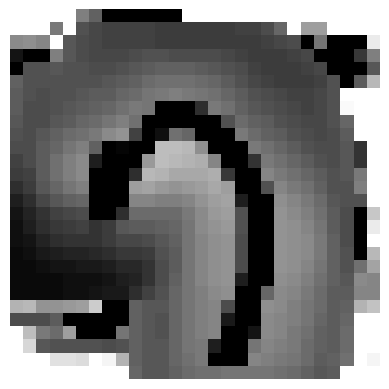

In [74]:

for i in range(batch):
    for name, example in [('benign', benign[i]), ('wasserstein', adv_wasser[i]), ('L2', adv_l2[i]), ('LInf', adv_linf[i]), ('SSIM', adv_ssim[i])]:
        ex = example.detach().reshape(28, 28)
        plt.imshow(ex, cmap='gray', vmin=0, vmax=1)
        plt.axis("off")
        plt.savefig(f"adversarials\\{name}_{i + 1}.png", bbox_inches="tight", pad_inches=0)

In [117]:
def cw_batch(model: nn.Module, benign_examples: torch.Tensor, labels: torch.Tensor, c_lambda: float, metric: Metric) -> torch.Tensor:
    adversarial_examples = 0.5 * torch.ones(benign_examples.shape) + 0.3 * (2 * torch.rand(benign_examples.shape) - 1)
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    step_size = 1e-2
    for i in range(100):
        adversarial_examples.requires_grad = True
        if adversarial_examples.grad is not None:
            adversarial_examples.grad.zero_()
        benign_examples.requires_grad = True
        if benign_examples.grad is not None:
            benign_examples.grad.zero_()
        metrics = metric(benign_examples, adversarial_examples)
        if (i + 1) % 10 == 0:
            print(metrics)
        metrics = 1 - (1 + metrics) / 2
        loss = metrics.sum() - c_lambda * loss_fn(model(adversarial_examples), torch.tensor(labels, dtype=torch.long))
        
        loss.backward()
        if (i + 1) % 10 == 0:
            print(adversarial_examples.grad)
        adversarial_examples = (adversarial_examples - step_size * adversarial_examples.grad.apply_(lambda x: 1 if x >= 0 else -1)).detach()
        # ex = adversarial_examples[0].detach().reshape(28, 28)
        # if (i + 1) % 10 == 0:   
        #     plt.imshow(ex, cmap='gray', vmin=0, vmax=1)
        #     plt.show()
    return adversarial_examples

In [121]:
wasscws = []
cs = [1000, 100, 10, 1, 0.1, 0.01, 0.001]
for c in cs:
    wasscws.append(cw_batch(model, benign, labels, c, WassersteinApproximation(regularization=3, iterations=10)))
    print(f'DONE SSIM {c}')

C:\Users\stani\AppData\Local\Temp\ipykernel_9400\2271204956.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = metrics.sum() - c_lambda * loss_fn(model(adversarial_examples), torch.tensor(labels, dtype=torch.long))


tensor([6.1864, 5.0424, 4.7770, 5.8662, 5.9838], grad_fn=<AliasBackward0>)
tensor([[[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]],


        [[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]],


        [[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]],


    

KeyboardInterrupt: 

In [113]:
cws = []
cs = [1000, 100, 10, 1, 0.1, 0.01, 0.001]
for c in cs:
    cws.append(cw_batch(model, benign, labels, c, StructuralSimilarityIndexMeasure(window_size=7, l=1)))
    print(f'DONE SSIM {c}')

C:\Users\stani\AppData\Local\Temp\ipykernel_9400\304463507.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = metrics.sum() - c_lambda * loss_fn(model(adversarial_examples), torch.tensor(labels, dtype=torch.long))


DONE SSIM 1000
DONE SSIM 100
DONE SSIM 10
DONE SSIM 1
DONE SSIM 0.1
DONE SSIM 0.01
DONE SSIM 0.001


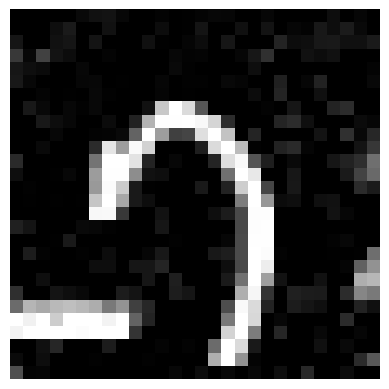

In [114]:
for i in range(batch):
    for c, example in [(cs[j], cws[j][i]) for j in range(len(cs))]:
        ex = example.detach().reshape(28, 28)
        plt.imshow(ex, cmap='gray', vmin=0, vmax=1)
        plt.axis("off")
        plt.savefig(f"adversarials\\cw\\ssim_c{c}_{i + 1}.png", bbox_inches="tight", pad_inches=0)